In [7]:
import os 
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm.invoke("hello")


AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond. The user says "hello". Just greet. Use friendly tone.'}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 72, 'total_tokens': 109, 'completion_time': 0.073751123, 'prompt_time': 0.002507769, 'queue_time': 0.049678956, 'total_time': 0.076258892}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_4a19b1544c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--baba80eb-b311-421a-943b-c1955a6acb2b-0', usage_metadata={'input_tokens': 72, 'output_tokens': 37, 'total_tokens': 109})

In [19]:
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

class Route(BaseModel):
    step:Literal["poem", "story", "joke"] = Field(description="The next step in routing process")

router = llm.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call_1(state:State):
    """ Write a story"""
    print("LLM call 1(story) is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state:State):
    """ Write a joke"""
    print("LLM call 2(joke) is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state:State):
    """ Write a poem"""
    print("LLM call 3(poem) is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state:State):
    """ Route the input to the appropriate node """
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story or joke or poem based on the users request"
            ), 
            HumanMessage(content=state["input"])
        ]
    )
    
    return {"decision": decision.step}

def route_decision(state:State):
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

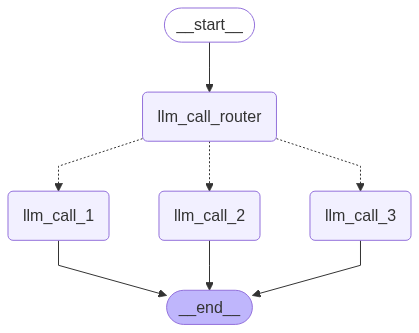

In [20]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

router_builder = StateGraph(State)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,{
        "llm_call_1":"llm_call_1",
        "llm_call_2":"llm_call_2",
        "llm_call_3":"llm_call_3"}
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

outer_workflow = router_builder.compile()
display(Image(outer_workflow.get_graph().draw_mermaid_png()))

In [21]:
state = outer_workflow.invoke({"input":"Write me a poem about superman"})
print(state["output"])

LLM call 3(poem) is called
**Ode to the Man of Steel**

In a sky where sunrise paints the clouds,  
A silvered silhouette cuts through the dawn,  
A lone star‑born heart that never bows,  
He carries hope where shadows have gone.  

From Krypton’s cradle, a distant fire,  
To Earth’s blue cradle, gentle and bright,  
He learned the weight of love, of loss, desire—  
A mantle forged in truth, not might.  

When cities tremble under thunder’s roar,  
And fear drapes its veil across the streets,  
He lifts the world, his cape a soaring shore,  
A beacon where the broken heart still beats.  

No crown of gold, no throne of stone,  
Just a simple “S” against the night—  
A symbol that we’re never truly alone,  
When courage rises, darkness takes flight.  

So let the wind whisper his name,  
Across the towers, over fields of grain—  
Superman, the echo of a promise:  
That within us all, a hero remains.
